In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pimg

from sklearn.metrics import accuracy_score

In [2]:
plt.rcParams["figure.figsize"] = [12, 9]

#### Metode za vizualizaciju grupe podataka

In [3]:
def show_batch(batch, preds=None):
    imgs, labels = batch
    N, _, H, W = imgs.shape
    r, c = [int(math.ceil(math.sqrt(N)))] * 2
    if preds is None:
        preds = torch.ones(N).long() * -1

    for i, (im, label, pred) in enumerate(zip(imgs, labels, preds)):
        plt.subplot(r,c,i+1)
        plt.imshow(im.numpy().squeeze(), cmap='gray')
        plt.title(f'Label: {label.item()} Prediction: {pred.item()}')
    plt.tight_layout()
    plt.show()

def show_errors(dataset, true, pred):
    missedd_indices = np.where(pred != true)[0][:16]
    missed_img = torch.stack([dataset[i][0] for i in missedd_indices])
    missed_lab, missed_pred = true[missedd_indices], pred[missedd_indices]
    show_batch((missed_img, missed_lab), preds=missed_pred)

#### Evaluacija

In [4]:
def evaluate(dataloader, size, model):
    preds, true = np.zeros((size,), dtype=np.uint8), np.zeros((size,), dtype=np.uint8)
    for step, (x, y) in enumerate(dataloader):
        logits = model(x)
        _, pred = logits.max(1)
        pred = pred.byte().cpu().numpy()
        t = y.byte().cpu().numpy()
        preds[step * len(pred): (step + 1) * len(pred)] = pred
        true[step * len(pred): (step + 1) * len(pred)] = t
    return accuracy_score(true, preds), true, preds

#### Konverzija iz NumPy polja u PyTorch 

In [5]:
def to_tensor(image):
    x = np.float32(image)
    x /= 255
    return torch.from_numpy(np.expand_dims(x, axis=0))

## Model logističke regresije
$\mathbf{s}(\mathbf{x}) = softmax(\mathbf{x} \mathbf{W} + \mathbf{b})$


In [6]:
class LogRegClassifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super(LogRegClassifier, self).__init__()
        self.W = nn.Parameter(data=torch.randn((num_features, num_classes)))
        self.b = nn.Parameter(data=torch.zeros(num_classes))

    def forward(self, input):
        x = input.view(input.size(0), -1)
        s = torch.mm(x, self.W) + self.b
        return s

In [7]:
mnist_train = MNIST(os.getcwd(), train=True, transform=to_tensor, download=True)
mnist_test = MNIST(os.getcwd(), train=False, transform=to_tensor, download=True)

In [8]:
model = LogRegClassifier(28 ** 2, 10)

In [9]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [10]:
dataloader_train = DataLoader(mnist_train, batch_size=16, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
dataloader_test = DataLoader(mnist_test, batch_size=16)

In [11]:
class Trainer(object):
    def __init__(self, loader_train, loader_test, model, criterion, optimizer, epochs):
        self.loader_train = loader_train
        self.loader_test = loader_test
        self.num_train = len(self.loader_train.dataset)
        self.num_test = len(self.loader_test.dataset)
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        pass

    def train(self):
        for e in range(self.epochs):
            steps = len(dataloader_train)
            for step, (x, y) in enumerate(self.loader_train):
                logits = self.model(x)
                loss = self.criterion(logits, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                if step % 1000 == 0:
                    print(f'Epoch {e+1}/{self.epochs} step {step}/{steps} loss: {loss.cpu().item():.2f}')
            acc_train, true_train, preds_train = evaluate(self.loader_train, self.num_train, self.model)
            acc_test, true_test, preds_test = evaluate(self.loader_test, self.num_test, self.model)
            print(f'Accuracy train: {100 * acc_train:.2f}%')
            print(f'Accuracy test: {100 * acc_test:.2f}%')
        return true_test, preds_test

In [12]:
with Trainer(dataloader_train, dataloader_test, model, criterion, optimizer, epochs=1) as trainer:
    true_test, preds_test = trainer.train()

Epoch 1/1 step 0/3750 loss: 15.26
Epoch 1/1 step 1000/3750 loss: 2.37
Epoch 1/1 step 2000/3750 loss: 1.17
Epoch 1/1 step 3000/3750 loss: 0.42
Accuracy train: 81.71%
Accuracy test: 82.58%


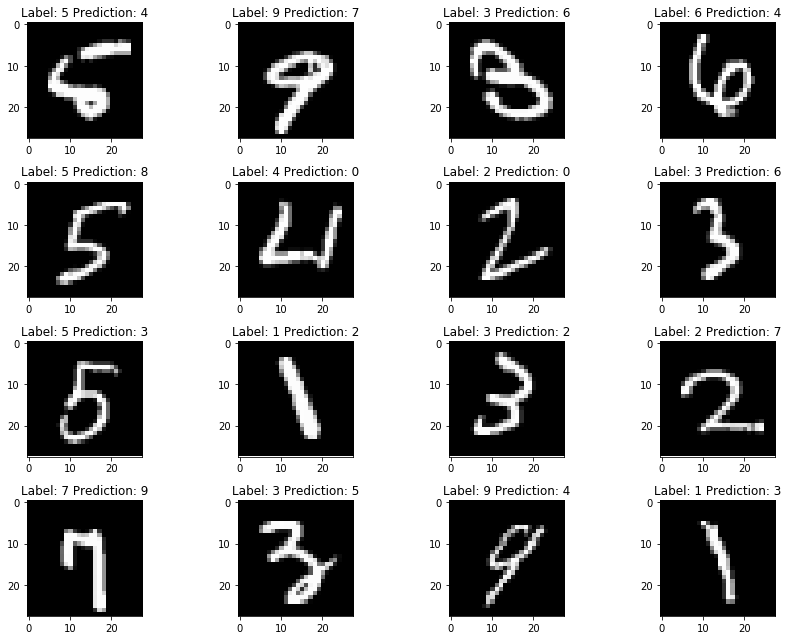

In [13]:
show_errors(mnist_test, true_test, preds_test)

## Duboki konvolucijski model
$conv(16,5) \rightarrow relu() \rightarrow pool(3,2) \rightarrow conv(32,5) \rightarrow relu() \rightarrow pool(3,2) \rightarrow fc(256) \rightarrow relu() \rightarrow fc(128) \rightarrow relu() \rightarrow fc(10)$

In [14]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 5),  # 24x24
            nn.ReLU(inplace=True),
            nn.AvgPool2d(3, stride=2),  # 11x11
            nn.Conv2d(16, 32, 5),  # 7x7
            nn.ReLU(inplace=True),
            nn.AvgPool2d(3, stride=2),  # 3x3
            Flatten(),  # 3*3*32
            nn.Linear(3 * 3 * 32, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        return self.model(x)

In [15]:
deep_model = ConvClassifier()

In [16]:
deep_optimizer = optim.Adam(deep_model.parameters(), lr=1e-3)

In [17]:
with Trainer(dataloader_train, dataloader_test, deep_model, criterion, deep_optimizer, epochs=1) as trainer:
    true_test, preds_test = trainer.train()

Epoch 1/1 step 0/3750 loss: 2.29
Epoch 1/1 step 1000/3750 loss: 0.05
Epoch 1/1 step 2000/3750 loss: 0.04
Epoch 1/1 step 3000/3750 loss: 0.04
Accuracy train: 97.81%
Accuracy test: 98.04%


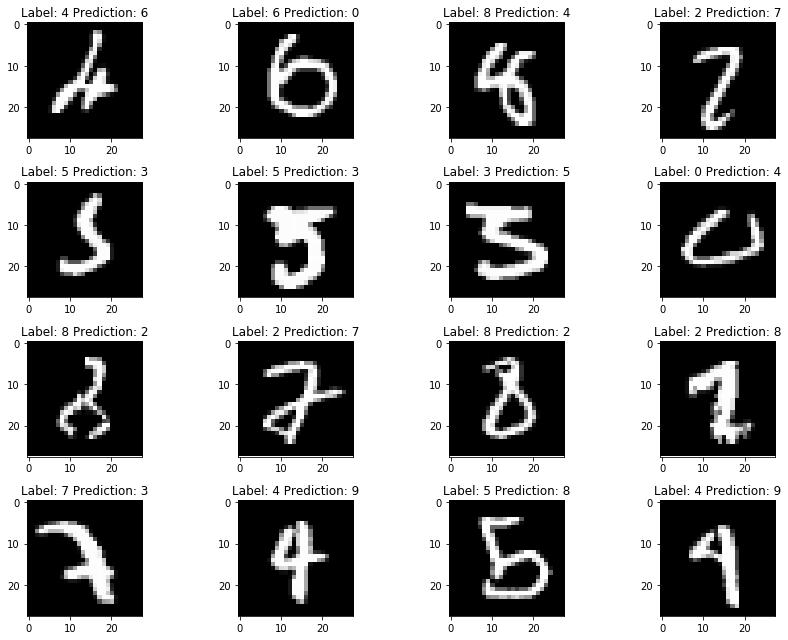

In [18]:
show_errors(mnist_test, true_test, preds_test)